In [1]:
import sys
sys.path.append("../..")
from community_accessibility import *

set_plot_formatting()

In [2]:
output_filename = 'output/community_accessibility_paper_results.h5'
gm_file = 'inputs/NSanAndreasMw725_UCERF2_Realizations.h5'

original_vulnerability_filename = '../inputs/Vulnerabilities_original.h5'
retrofit_vulnerability_filename = '../inputs/Vulnerabilities_retrofits.h5'

mapped_inventory_file = 'gis_data/Downtown.geojson'

gm_file = '../inputs/NSanAndreasMw725_UCERF2_Realizations.h5'
rupture_geojson_file = 'gis_data/CAPSS_rupture_locations.geojson'
# ca_geojson_file = 'gis_data/CA_polygon.geojson'
# soil_geojson_file = 'gis_data/SF_soil.geojson'

# sf_boundary_file = 'gis_data/SF Shoreline and Islands.geojson'
# other_buildings_file = 'gis_data/Districts3and6.geojson'

In [4]:
# set default case and the rupture index
case = 'baseline'
i_rup = 0

In [5]:
bldgs = pd.read_hdf(output_filename, key='MetaData/buildings')
bldg_ids = bldgs.index.values

mapped_bldgs = gpd.read_file(mapped_inventory_file)
mapped_bldgs.set_index('id', inplace=True)
mapped_bldgs['building.period'] = bldgs['building.period']
mapped_bldgs = mapped_bldgs.loc[bldg_ids,:]

ruptures = pd.read_hdf(output_filename, key='MetaData/ruptures')
rupture_ids = ruptures.index.values
# mapped_ruptures = gpd.read_file(rupture_geojson_file)
# ca_map = gpd.read_file(ca_geojson_file)
# sf_boundary_map = gpd.read_file(sf_boundary_file)
# other_buildings = gpd.read_file(other_buildings_file)
# soils = gpd.read_file(soil_geojson_file)
# soils['vs30'] = soils['Vs30'].astype(str)

# sites = pd.read_hdf(gm_file, key='Sites')
# sites['vs30'] = sites['Vs30'].astype(str)
# geometry = [Point(xy) for xy in zip(sites.Longitude, sites.Latitude)]
# sites = gpd.GeoDataFrame(sites, geometry=geometry)
# sites.crs = {'init': 'epsg:4326'}
    
with h5py.File(output_filename, 'r') as hf:

    cases = ast.literal_eval(hf['Results'].attrs.__getitem__('contents'))
    i_damage = cases[case]['i_damage']
    i_impeding_factors = cases[case]['i_impeding_factors']
    i_cordons = cases[case]['i_cordons']
    description = cases[case]['description']

    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/Hazard_and_Vulnerability_Sampling/ground_motion_map_indices'
    gm_map_indices = hf[dset][:]
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/community_damage'
    community_damage = hf[dset][:]
    damage_parameters = hf[dset].attrs.__getitem__('damage_parameters')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons)
    cordon_height_threshold = hf[dset].attrs.__getitem__('height_threshold')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/community_downtime'
    community_downtime = hf[dset][:]
    downtime_parameters = hf[dset].attrs.__getitem__('downtime_parameters')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/community_recovery'
    community_recovery = 100 * hf[dset][:]
    time = hf[dset].attrs.__getitem__('time')
    recovery_labels = hf[dset].attrs.__getitem__('recovery_labels')
    occupancy_labels = hf[dset].attrs.__getitem__('occupancy_labels')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/CordonNetwork' +\
             '/cordon_durations'
    cordon_durations = hf[dset][:]
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/CordonNetwork' +\
             '/cordon_duration_adjacency'
    cordon_duration_adjacency = hf[dset][:]
    
    key = '/Results/'+\
          '/CommunityDamage_' + str(i_damage) + \
          '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
          '/CordonLogistics/Cordons_' + str(i_cordons) + \
          '/CordonNetwork/' + 'cordon_locations'
    cordon_locations = pd.read_hdf(output_filename, key=key)
    dset = hf[key]
    cordon_map = eval(dset.attrs.__getitem__('cordon_map'))
    cordon_map = gpd.GeoDataFrame.from_features(cordon_map)
    cordon_map.set_index('id', drop=True, inplace=True)
    cordon_map.crs = {'init': 'epsg:4326'}

C:\Users\ahul697\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
# convert geopandas to desired projection
mapped_bldgs = mapped_bldgs.to_crs(epsg=2227)
# sites = sites.to_crs(epsg=2227)
cordon_map = cordon_map.to_crs(epsg=2227)
# mapped_ruptures = mapped_ruptures.to_crs(epsg=2227)
# ca_map = ca_map.to_crs(epsg=2227)
# soils = soils.to_crs(epsg=2227)
# sf_boundary_map = sf_boundary_map.to_crs(epsg=2227)
# other_buildings = other_buildings.to_crs(epsg=2227)

### scatter plot for cordons

In [11]:
#### prepare data for the number of cordons

# count number of cordons
cordon_presence = cordon_durations > 0
[_,n_tall,n_realizations] = cordon_presence.shape
cordon_counts = np.sum(cordon_presence, axis=1)

# get histogram info for identifying percentiles
bins = np.arange(n_tall)
[p_tall,_,_] = plt.hist(cordon_counts[i_rup,:], bins=bins, density=True, cumulative=True, histtype='step')
_ = plt.close()

# get histrogram info for plotting the number of cordons
n_bins = int(n_tall/2)
[counts_tall,edges_tall] = np.histogram(cordon_counts[i_rup,:], bins=n_bins)


#### prepare data for the affected buildings

# affected buildings that do not have their own cordons
affected_buildings = np.sum(cordon_duration_adjacency, axis=2) > 0

## add the tall buildings that are causing the cordons

# get the index of the tall buildings
df = bldgs.copy()
hgt_col = 'building.building_ht_ft'
df_tall = df[df[hgt_col] >= cordon_height_threshold]
height = df_tall[hgt_col].values
tall_idx = np.where(df[hgt_col] >= cordon_height_threshold)[0]

# add the cordoned tall buildings to the affected buildings
affected_buildings[0,tall_idx,:] = affected_buildings[0,tall_idx,:] | cordon_presence[0,:,:]

0.25th percentile: 109
0.5th percentile: 374
0.75th percentile: 680


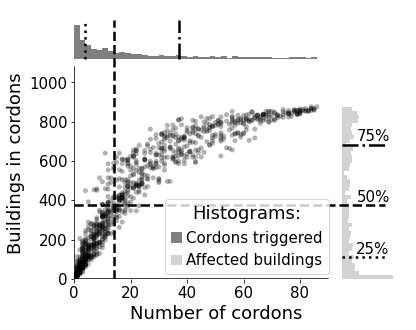

In [13]:
# count number of affected buildings
[_, n_bldgs,n_realizations] = affected_buildings.shape
affected_building_counts = np.sum(affected_buildings, axis=1)

# get histogram info for identifying percentiles
bins = np.arange(n_bldgs)
[p_all,_,_] = plt.hist(affected_building_counts[i_rup,:], bins=bins, density=True, cumulative=True, histtype='step')
_ = plt.close()

# get histrogram info for plotting the number of affected buildings
n_bins = int(n_bldgs/25)
[counts_all,edges_all] = np.histogram(affected_building_counts[i_rup,:], bins=n_bins)



# start plotting
fig, ax = plt.subplots(1,1,figsize=(6, 5))

# specify how many/which points to use
n_points = int(n_realizations / 1) # all points
pt_where = np.random.choice(n_realizations, n_points, replace=False)
pt_idx = np.zeros(n_realizations, dtype='bool')
pt_idx[pt_where] = True

# plot the data to see the correlation
_ = ax.scatter(cordon_counts[i_rup,pt_idx],affected_building_counts[i_rup,pt_idx], color='k', edgecolor='none', alpha=0.3, s=25)

ylim = [0,1078]
hist_bottom = ylim[1]+40
hist_top = hist_bottom + 200

# plot the two histograms
tall_hist = ax.bar(edges_tall[:-1], 1.1*counts_tall, bottom=hist_bottom, width=(edges_tall[1]-edges_tall[0]), align='edge', color='tab:gray', label='Cordons triggered')
all_hist = ax.barh(edges_all[:-1], 0.15*counts_all, left=95, height=(edges_all[1]-edges_all[0]), align='edge', color='lightgray', label='Affected buildings')


_ = ax.plot([0, 90], [0,0], color='k')
_ = ax.plot([0, 0], ylim, color='k')

# add lines to show the percentiles in the histograms
linestyles=[':','--','-.']
p = [0.25, .5, .75]
p_handles = list()
for i in range(len(p)):
    idx = np.searchsorted(p_all,p[i])
    print('%sth percentile: %s' %(p[i]*100,idx))
    if p[i] == 0.5:
        line_min = 0
    else:
        line_min = 95
    _ = ax.plot([line_min,110], [idx]*2, linestyle=linestyles[i], color='k', linewidth=2.5)
    _ = ax.text(100, idx+5, ('{:.0f}'.format(100*p[i])+'%'), ha='left', va='bottom', color='black', fontsize='medium', zorder=20)
    
    idx = np.searchsorted(p_tall,p[i])
    if p[i] == 0.5:
        line_min = 0
        line_max = hist_top
    else:
        line_min = hist_bottom
        line_max = hist_top
    _ = ax.plot([idx]*2, [line_min,line_max], linestyle=linestyles[i], color='k', linewidth=2.5)

# add additional plot features
_ = ax.set_xlabel('Number of cordons         ')
_ = ax.set_ylabel('Buildings in cordons       ')

_ = plt.legend(title='Histograms:', title_fontsize='large',
               loc='lower left', bbox_to_anchor=(0.25, -0.01),
               handlelength=0.7, handletextpad=0.3)               

_ = [s.set_visible(False) for s in ax.spines.values()]
_ = ax.set_xlim(left=0)
_ = ax.set_ylim(bottom=0)

yticks = ax.get_yticks()
_ = ax.set_yticks(yticks[:-2])

xticks = ax.get_xticks()
_ = ax.set_xticks(xticks[:-2])


filename = 'cordon_count_scatter'
_ = plt.savefig('figures_png/'+filename+'.png', dpi=500, bbox_inches='tight')
_ = plt.savefig('figures_pdf/'+filename+'.pdf', bbox_inches='tight')

25.0th percentile: 16
50.0th percentile: 53
75.0th percentile: 86


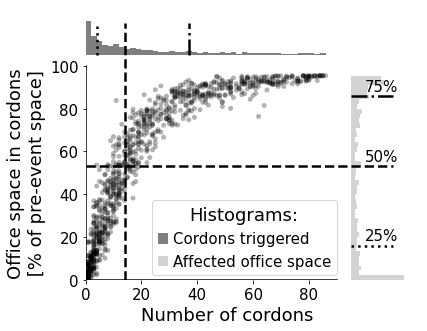

In [15]:
# area of affected office buildings
[n_rups, n_bldgs,n_realizations] = affected_buildings.shape

office_idx = bldgs['building.occupancy_id']=='Commercial Office'

total_area = np.sum(bldgs.loc[office_idx,'building.total_area_ft'])
cordoned_area_counts = np.array([np.array([np.sum(affected_buildings[i,office_idx,i_rlz] * bldgs.loc[office_idx,'building.total_area_ft']) for i_rlz in range(n_realizations)]) for i in range(n_rups)])
cordoned_fraction_counts = cordoned_area_counts / total_area * 100

# get histogram info for identifying percentiles
bins = np.arange(100)
[p_all,_,_] = plt.hist(cordoned_fraction_counts[i_rup,:], bins=bins, density=True, cumulative=True, histtype='step')
_ = plt.close()

# get histrogram info for plotting the number of affected buildings
n_bins = int(n_bldgs/25)
[counts_all,edges_all] = np.histogram(cordoned_fraction_counts[i_rup,:], bins=n_bins)



# start plotting
fig, ax = plt.subplots(1,1,figsize=(6, 5))

# specify how many/which points to use
n_points = int(n_realizations / 1) # all points
pt_where = np.random.choice(n_realizations, n_points, replace=False)
pt_idx = np.zeros(n_realizations, dtype='bool')
pt_idx[pt_where] = True

# plot the data to see the correlation
_ = ax.scatter(cordon_counts[i_rup,pt_idx],cordoned_fraction_counts[i_rup,pt_idx], color='k', edgecolor='none', alpha=0.3, s=25)

ylim = [0,100]
hist_bottom = ylim[1] + 5
hist_top = hist_bottom + 15

# plot the two histograms
tall_hist = ax.bar(edges_tall[:-1], 0.1*counts_tall, bottom=hist_bottom, width=(edges_tall[1]-edges_tall[0]), align='edge', color='tab:gray', label='Cordons triggered')
all_hist = ax.barh(edges_all[:-1], 0.15*counts_all, left=95, height=(edges_all[1]-edges_all[0]), align='edge', color='lightgray', label='Affected office space')


_ = ax.plot([0, 90], [0,0], color='k')
_ = ax.plot([0, 0], ylim, color='k')

# add lines to show the percentiles in the histograms
linestyles=[':','--','-.']
p = [0.25, .5, .75]
p_handles = list()
for i in range(len(p)):
    idx = np.searchsorted(p_all,p[i])
    print('%sth percentile: %s' %(p[i]*100,idx))
    if p[i] == 0.5:
        line_min = 0
    else:
        line_min = 95
    _ = ax.plot([line_min,110], [idx]*2, linestyle=linestyles[i], color='k', linewidth=2.5)
    _ = ax.text(100, idx+1, ('{:.0f}'.format(100*p[i])+'%'), ha='left', va='bottom', color='black', fontsize='medium', zorder=20)
    
    idx = np.searchsorted(p_tall,p[i])
    if p[i] == 0.5:
        line_min = 0
        line_max = hist_top
    else:
        line_min = hist_bottom
        line_max = hist_top
    _ = ax.plot([idx]*2, [line_min,line_max], linestyle=linestyles[i], color='k', linewidth=2.5)

# add additional plot features
_ = ax.set_xlabel('Number of cordons         ')
_ = ax.set_ylabel('Office space in cordons          \n [% of pre-event space]           ')

_ = plt.legend(title='Histograms:', title_fontsize='large',
               loc='lower left', bbox_to_anchor=(0.175, -0.01),
               handlelength=0.7, handletextpad=0.3)               

_ = [s.set_visible(False) for s in ax.spines.values()]
_ = ax.set_xlim(left=0)
_ = ax.set_ylim(bottom=0)

yticks = ax.get_yticks()
_ = ax.set_yticks(yticks[:-2])

xticks = ax.get_xticks()
_ = ax.set_xticks(xticks[:-2])


filename = 'cordoned_office_area_count_scatter'
_ = plt.savefig('figures_png/'+filename+'.png', dpi=500, bbox_inches='tight')
_ = plt.savefig('figures_pdf/'+filename+'.pdf', bbox_inches='tight')

### recovery maps

In [90]:
def plot_recovery_map_at_time(time, ax, xlim, ylim, legend, community_downtime, i_rup, i_sim, downtime_parameters, mapped_bldgs, cordon_map):
    
    plt.cla()
    
    # set colors
    color_values = [0.15, 0.35, 0.65, 0.9]
    color_palettes = ['Greens', 'Greys', 'Oranges', 'Blues']
    colors = [mpl.cm.get_cmap(color_palettes[i])(color_values[i])[:-1] for i in range(len(color_values))] 
    colors = [mpl.colors.to_hex(colors[i]) for i in range(len(colors))]
    
    # indices for retrieve the final time for each phase of the downtime
    total_downtime_idx = np.where(downtime_parameters=='total_downtime')[0]
    total_delay_idx = np.where(downtime_parameters=='total_delay')[0]
    if_delay = np.where(downtime_parameters=='impeding_factor_delay')[0]
    
    # create new dfs containing only the data for the desired simulation
    temp_map = mapped_bldgs.copy()
    temp_map['total_downtime'] = np.squeeze(community_downtime[i_rup,:,total_downtime_idx,i_sim])
    temp_map['total_delay'] = np.squeeze(community_downtime[i_rup,:,total_delay_idx,i_sim])
    temp_map['impeding_factor_delay'] = np.squeeze(community_downtime[i_rup,:,if_delay,i_sim])
    
    temp_cordon_map = cordon_map.copy()
    temp_cordon_map['duration'] = np.squeeze(cordon_durations[i_rup,:,i_sim])
    
    days = 30*time
    
    # background color for all buildings
    _ = temp_map.plot(ax=ax, color=colors[0])

    # all buildings that are not yet accessible at the specified time
    idx = temp_map['total_downtime'] > days
    if sum(idx) > 0 :
        _ = temp_map[idx].plot(ax=ax, color=colors[1])

    # all buildings that are not yet being repaired at the specified time
    idx = temp_map['total_delay'] > days
    if sum(idx) > 0 :
        _ = temp_map[idx].plot(ax=ax, color=colors[2])

    # all buildings that are still in the impeding factor phase the specified time
    idx = temp_map['impeding_factor_delay'] > days
    if sum(idx) > 0 :
        _ = temp_map[idx].plot(ax=ax, color=colors[3])
        
    # all cordons that are present at the specified time
    idx = temp_cordon_map['duration'] > days
    if sum(idx) > 0 :
        _ = temp_cordon_map[idx].plot(ax=ax, color='none', edgecolor='k', linewidth=1.5)

    
    _ = ax.set_xlim(xlim)
    _ = ax.set_ylim(ylim)
    
    if legend:
        legend_elements = [Patch(facecolor=colors[3], label='Impeding factors'),
                           Patch(facecolor=colors[2], label='Cordon delay'),
                           Patch(facecolor=colors[1], label='Repair initiated'),
                           Patch(facecolor=colors[0], label='Accessible'),
                           Patch(facecolor='white'),
                           Patch(facecolor='none', edgecolor='k', linewidth=1.5, label='Cordon perimeter')]
        _ = ax.legend(handles=legend_elements, handlelength=1, bbox_to_anchor=(1,0.5), loc='center left', title='Building Status') 
    
    title = '\nMonths after the earthquake: ' + '{:.0f}'.format(time)
    _ = ax.set_title(title)
    _ = ax.axis('off')
    _ = plt.tight_layout()

#### get simulations with the median number of cordons

Median number of cordons: 14


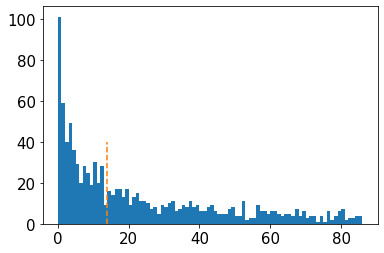

In [46]:
cordon_presense = cordon_durations > 0
cordon_count = np.sum(cordon_presense, axis=1)

[_, n_tall, _] = cordon_presense.shape
bins = np.arange(n_tall)
_ = plt.hist(cordon_count[i_rup,:], bins=bins)

n_median = int(np.median(cordon_count[i_rup,:]))
_ = plt.plot([n_median]*2, [0,40], linestyle='--')

print('Median number of cordons: ' + '{:.0f}'.format(n_median))

median_idx = np.where(cordon_count[i_rup,:]==n_median)[0]

#### look at multiple maps to select one

In [47]:
def plot_recovery_map_at_time(time, ax, xlim, ylim, legend, community_downtime, i_rup, i_sim, downtime_parameters, mapped_bldgs, cordon_map):
    
    plt.cla()
    
    color_values = [0.15, 0.35, 0.65, 0.9]
    color_palettes = ['Greens', 'Greys', 'Oranges', 'Blues']
    colors = [mpl.cm.get_cmap(color_palettes[i])(color_values[i])[:-1] for i in range(len(color_values))] 
    if False:
        colors = [grayscale_version(colors[i]) for i in range(len(colors))]
    colors = [mpl.colors.to_hex(colors[i]) for i in range(len(colors))]
    
    
    total_downtime_idx = np.where(downtime_parameters=='total_downtime')[0]
    total_delay_idx = np.where(downtime_parameters=='total_delay')[0]
    if_delay = np.where(downtime_parameters=='impeding_factor_delay')[0]
    
    temp_map = mapped_bldgs.copy()
    temp_map['total_downtime'] = np.squeeze(community_downtime[i_rup,:,total_downtime_idx,i_sim])
    temp_map['total_delay'] = np.squeeze(community_downtime[i_rup,:,total_delay_idx,i_sim])
    temp_map['impeding_factor_delay'] = np.squeeze(community_downtime[i_rup,:,if_delay,i_sim])
    
    temp_cordon_map = cordon_map.copy()
    temp_cordon_map['duration'] = np.squeeze(cordon_durations[i_rup,:,i_sim])
    
    days = 30*time
    
    _ = temp_map.plot(ax=ax, color=colors[0])

    idx = temp_map['total_downtime'] > days
    if sum(idx) > 0 :
        _ = temp_map[idx].plot(ax=ax, color=colors[1])

    idx = temp_map['total_delay'] > days
    if sum(idx) > 0 :
        _ = temp_map[idx].plot(ax=ax, color=colors[2])

    idx = temp_map['impeding_factor_delay'] > days
    if sum(idx) > 0 :
        _ = temp_map[idx].plot(ax=ax, color=colors[3])
        
    idx = temp_cordon_map['duration'] > days
    if sum(idx) > 0 :
        _ = temp_cordon_map[idx].plot(ax=ax, color='none', edgecolor='k', linewidth=1.5)

    
    _ = ax.set_xlim(xlim)
    _ = ax.set_ylim(ylim)
    
    if legend:
        legend_elements = [Patch(facecolor=colors[3], label='Impeding factors'),
                           Patch(facecolor=colors[2], label='Cordon Delay'),
                           Patch(facecolor=colors[1], label='Repair initiated'),
                           Patch(facecolor=colors[0], label='Functional'),
                           Patch(facecolor='white'),
                           Patch(facecolor='none', edgecolor='k', linewidth=1.5, label='Cordon perimeter')]
        _ = ax.legend(handles=legend_elements, bbox_to_anchor=(1,0.5), loc='center left', handlelength=1) 
    
    title = '\nMonths after the earthquake: ' + '{:.0f}'.format(time)
    _ = ax.set_title(title)
    _ = ax.axis('off')
    _ = plt.tight_layout()

Rupture: 0, Realization: 62


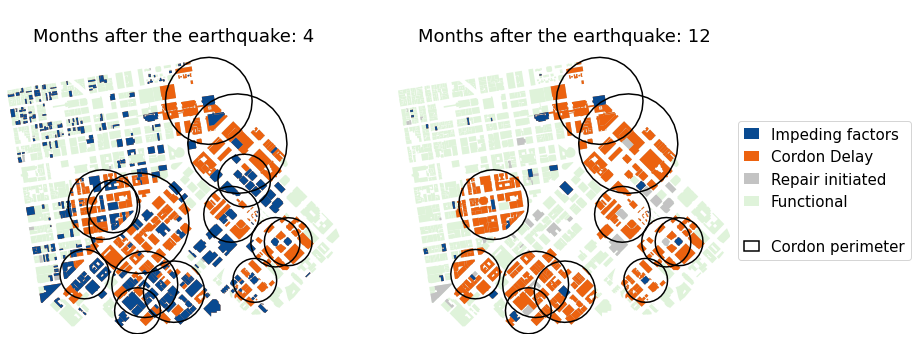

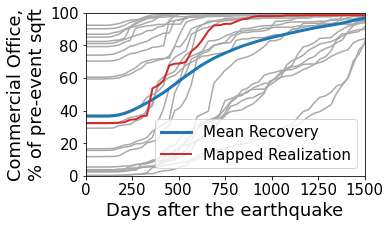

Rupture: 0, Realization: 69


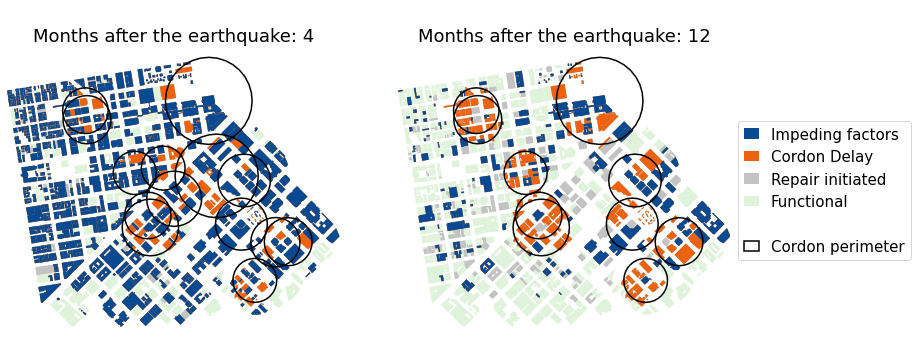

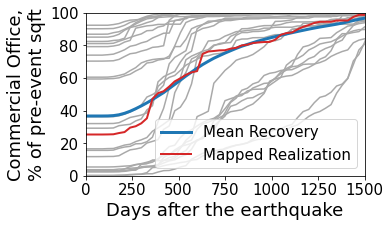

Rupture: 0, Realization: 75


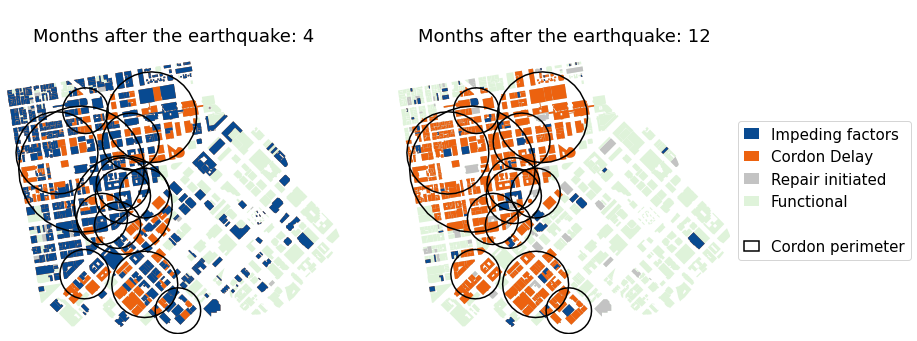

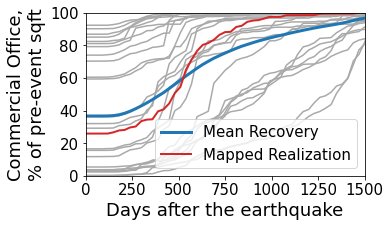

Rupture: 0, Realization: 115


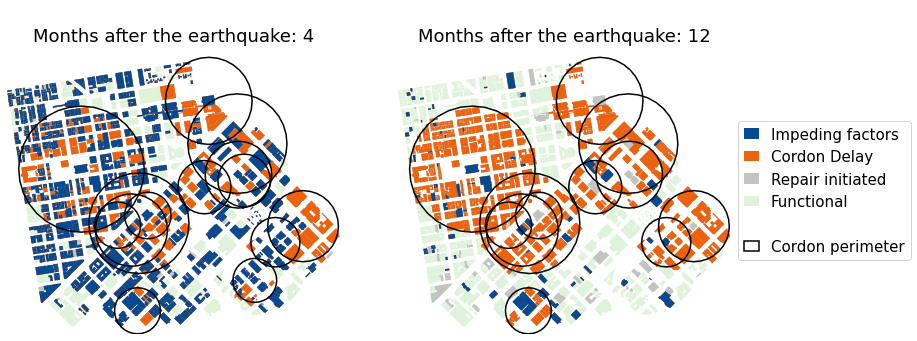

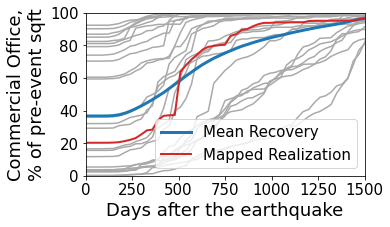

Rupture: 0, Realization: 296


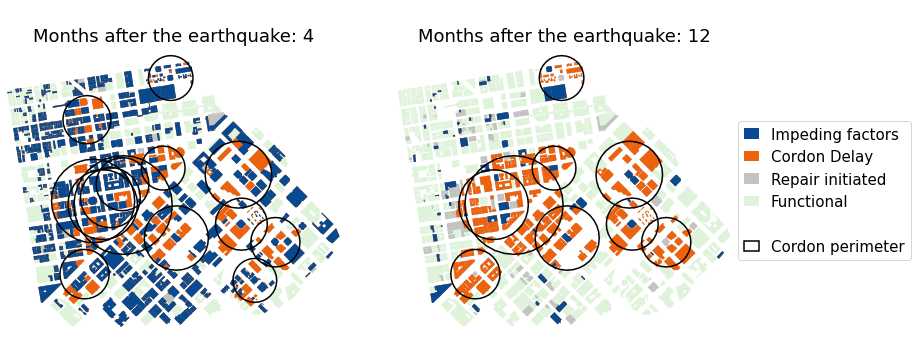

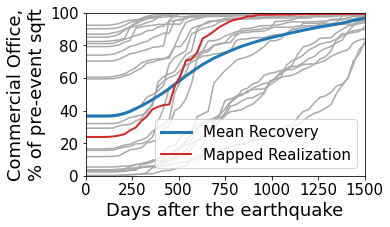

Rupture: 0, Realization: 311


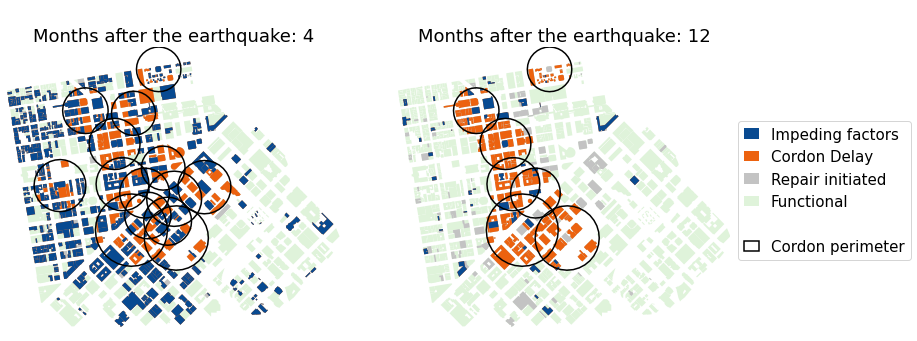

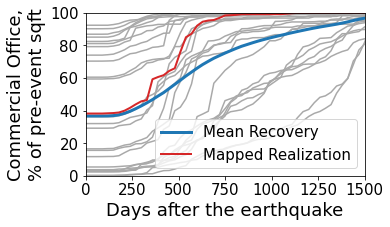

Rupture: 0, Realization: 497


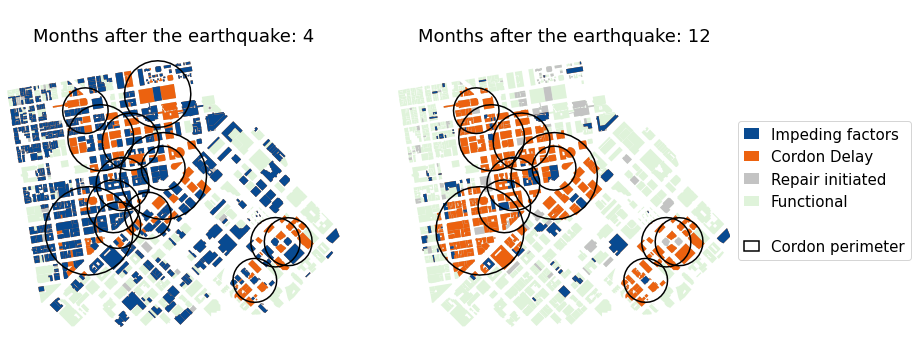

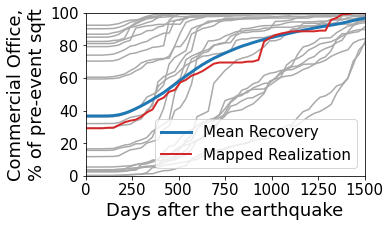

Rupture: 0, Realization: 706


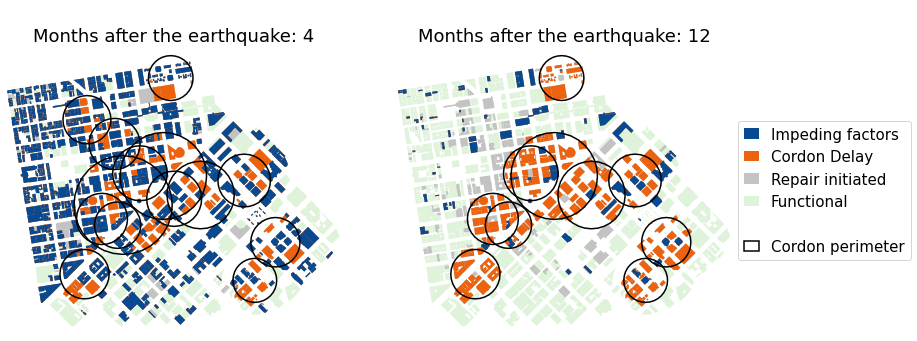

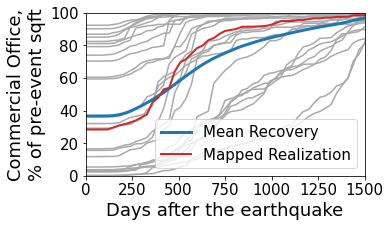

Rupture: 0, Realization: 714


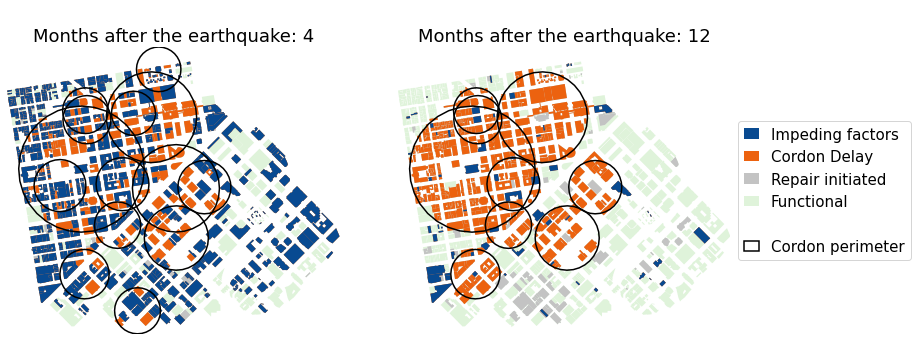

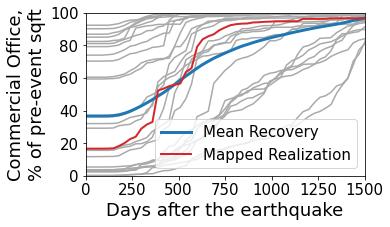

Rupture: 0, Realization: 792


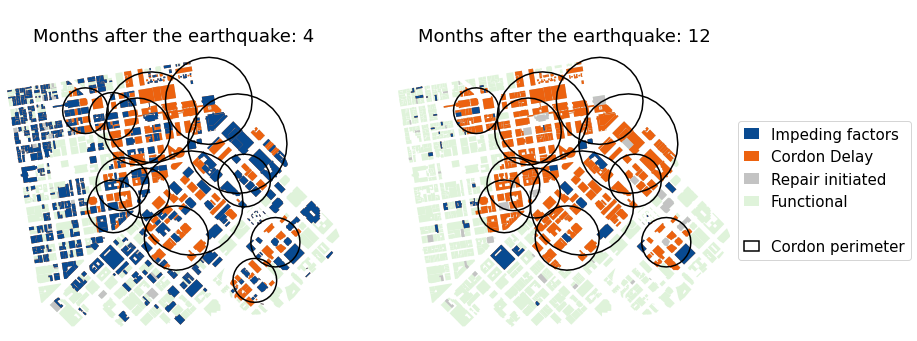

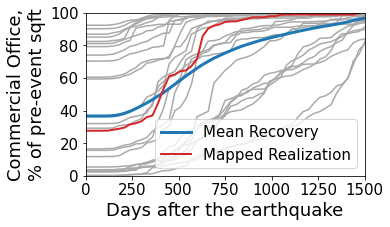

In [48]:
# set bounds for the map
[cordon_minx, cordon_miny] = np.min(cordon_map.bounds.values[:,:2],axis=0)
[cordon_maxx, cordon_maxy] = np.max(cordon_map.bounds.values[:,2:],axis=0)

[bldgs_minx, bldgs_miny] = np.min(mapped_bldgs.bounds.values[:,:2],axis=0)
[bldgs_maxx, bldgs_maxy] = np.max(mapped_bldgs.bounds.values[:,2:],axis=0)

xlim = [min(bldgs_minx,cordon_minx),max(bldgs_maxx,cordon_maxx)]
ylim = [min(bldgs_miny,cordon_miny),max(bldgs_maxy,cordon_maxy)]

# loop through simulations with the median number of cordons
for i_sim in median_idx[0:10]:
    print('Rupture: ' + str(i_rup) + ', Realization: ' + str(i_sim))
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    # specify time for left and right plots
    time_stamps = [4,12]
    legend = [False, True]
    for i in range(2):   
        plot_recovery_map_at_time(time_stamps[i], ax[i], xlim, ylim, legend[i], community_downtime, i_rup, i_sim, downtime_parameters, mapped_bldgs, cordon_map)

    filename = 'recovery_map_' + case + '_rup' + str(i_rup) + '_sim' + str(i_sim)    
    _ = plt.show()

    # add a plot to show how close the recovery is to the median
    rec_idx = np.where(recovery_labels=='total_downtime')[0]
    occ_idx = np.where(occupancy_labels=='Commercial Office')[0]

    fig, ax = plt.subplots(1,1, figsize=(5,3))
    [_,_,_,_,n_sims] = community_recovery.shape
    sims_idx = range(1, n_sims, 41)
    _ = plt.plot(time, np.squeeze(community_recovery[:,i_rup,occ_idx,rec_idx,sims_idx]), color='darkgray')
    _ = plt.plot(time, np.mean(np.squeeze(community_recovery[:,i_rup,occ_idx,rec_idx,:]), axis=1), color='tab:blue', linewidth=3, label='Mean Recovery')
    _ = plt.plot(time, community_recovery[:,i_rup,occ_idx,rec_idx,i_sim], color='tab:red', linewidth=2, label='Mapped Realization')
    _ = plt.xlim([0,1500])
    _ = plt.ylim([0,100])
    ylabel = occupancy_labels[occ_idx][0]+',\n% of pre-event sqft'
    _ = plt.ylabel(ylabel)
    _ = plt.xlabel('Days after the earthquake')
    _ = plt.legend()
    _ = plt.show()

#### selected realization for the saved figure

Rupture: 0, Realization: 706


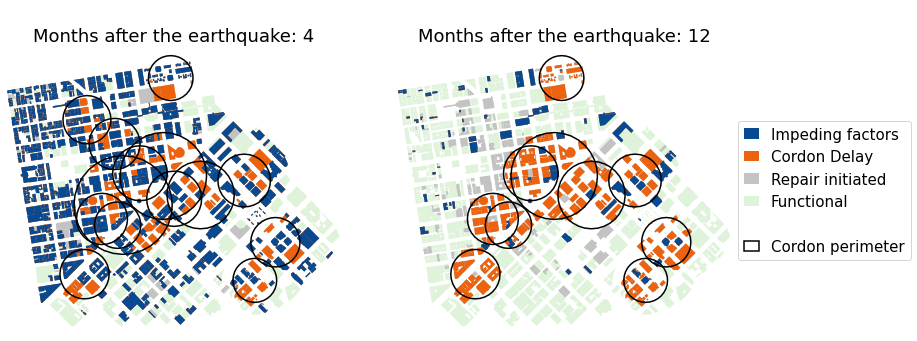

In [49]:
realization_idx = [706]

for i_sim in realization_idx:
    print('Rupture: ' + str(i_rup) + ', Realization: ' + str(i_sim))
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    time_stamps = [4,12]
    legend = [False, True]
    for i in range(2):   
        plot_recovery_map_at_time(time_stamps[i], ax[i], xlim, ylim, legend[i], community_downtime, i_rup, i_sim, downtime_parameters, mapped_bldgs, cordon_map)

    filename = 'recovery_map_' + case + '_rup' + str(i_rup) + '_sim' + str(i_sim)    
    _ = plt.savefig('figures_pdf/'+filename+'.pdf', bbox_inches='tight')
    _ = plt.savefig('figures_png/'+filename+'.png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

    _ = plt.show()

### community metrics summary

#### retrive the summary metrics for all cases

In [6]:
# case_names = list(cases.keys())
case_names = ['baseline',
             'no_cordon',
             'cordon_extent',
             'tall_mitigation_contr',
             'tall_mitigation_eng',
             'tall_mitigation_finance',
             'tall_mitigation_all',
             'tall_retrofit',
             'all_bldgs_0.5_impeding_factors',
             'cordons_no_impeding_factors']

# set values for calculating metrics
loss_col = 'Mean Community Days Lost'
time_frame = 12 * 30
time_frame_col = 'Mean community days lost\nwithin the first year'
community_threshold = 0.80
community_threshold_col = 'Days until mean recovery\nis at ' + '{:.0f}'.format(100*community_threshold) + '% functionality'

target_time = np.array([4, 12])
target_threshold = np.array([0.5, 0.5])

summary_results = pd.DataFrame(index=case_names)
summary_results[loss_col] = ''
summary_results[time_frame_col] = ''
summary_results[community_threshold_col] = ''

policy_col = list()
for p in range(len(target_time)):
    policy_col.append('% Likelihood of achieving\n' + '{:.0f}'.format(100*target_threshold[p]) + '% functionality in ' + '{:.0f}'.format(target_time[p]) + ' months')
    summary_results[policy_col[p]] = ''
    
deag_col = list()
deag_type = ['functional_repair', 'impeding_factor_delay', 'cordon_induced_delay']
for d in range(len(deag_type)):
    deag_col.append(deag_type[d] + ' losses in the first year')
    summary_results[deag_col[d]] = ''


i_occ = 1

ruptures[i_rup:i_rup+1]

for case in case_names:
    
    i_damage = cases[case]['i_damage']
    i_impeding_factors = cases[case]['i_impeding_factors']
    i_cordons = cases[case]['i_cordons']
    description = cases[case]['description']

    with h5py.File(output_filename, 'r') as hf:
        dset =   'Results' + \
                 '/CommunityDamage_' + str(i_damage) + \
                 '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
                 '/CordonLogistics/Cordons_' + str(i_cordons) + \
                 '/community_recovery'

        community_recovery = hf[dset][:]
        time = hf[dset].attrs.__getitem__('time')
        recovery_labels = hf[dset].attrs.__getitem__('recovery_labels')
        occupancy_labels = hf[dset].attrs.__getitem__('occupancy_labels')
        sqft_totals = hf[dset].attrs.__getitem__('sqft_totals')
        downtime_idx = np.where(recovery_labels=='total_downtime')[0]

    [_,_,_,_,n_sims] = community_recovery.shape
    for p in range(len(target_time)):
        time_idx = np.where(time == 30*target_time[p])[0]
        recovery_slice = np.squeeze(community_recovery[time_idx,i_rup,i_occ,downtime_idx,:])
        threshold_idx = np.searchsorted(np.sort(recovery_slice), target_threshold[p])
        summary_results.loc[case, policy_col[p]] = np.rint(100 * (1 - threshold_idx/n_sims))

    mean_community_recovery = np.mean(community_recovery, axis=4)

    days_to_community_threshold = np.interp(community_threshold, np.squeeze(mean_community_recovery[:, i_rup, i_occ, downtime_idx]), time)
    summary_results.loc[case, community_threshold_col] = np.rint(days_to_community_threshold)

    baseline_time = np.trapz(np.ones(len(time)), time)
    downtime = np.squeeze(mean_community_recovery[:, i_rup, i_occ, downtime_idx])
    downtime = (baseline_time - np.trapz(downtime, time))       
    summary_results.loc[case, loss_col] = np.rint(downtime)

    if time_frame is not None:
        n_time = np.where(time == time_frame)[0][0]+1
        time = time[:n_time]
        mean_community_recovery = mean_community_recovery[:n_time,:,:,:]

    baseline_time = np.trapz(np.ones(len(time)), time)
    downtime = np.squeeze(mean_community_recovery[:, i_rup, i_occ, downtime_idx])
    downtime = (baseline_time - np.trapz(downtime, time))       
    summary_results.loc[case, time_frame_col] = np.rint(downtime)
    
    lower_limit = 0
    idx_names = ['functional_repair', 'functional_downtime', 'total_downtime']
    for d in range(len(deag_type)):
        rec_idx = np.where(recovery_labels==idx_names[d])[0]
        loss = np.squeeze(mean_community_recovery[:, i_rup, i_occ, rec_idx])
        loss = (baseline_time - np.trapz(loss, time)) - lower_limit
        lower_limit = lower_limit + loss
        summary_results.loc[case, deag_col[d]] = np.rint(loss)
    
summary_results 

Magnitude  SourceIndex  RuptureIndex
0       7.25          127           637

Mean Community Days Lost  \
baseline                                            467   
no_cordon                                           283   
cordon_extent                                       394   
tall_mitigation_contr                               421   
tall_mitigation_eng                                 464   
tall_mitigation_finance                             469   
tall_mitigation_all                                 399   
tall_retrofit                                       331   
all_bldgs_0.5_impeding_factors                      355   
cordons_no_impeding_factors                         350   

                               Mean community days lost\nwithin the first year  \
baseline                                                                   219   
no_cordon                                                                  144   
cordon_extent                                                              191   
tall_mitigation_contr                                                      213   
tall_mitigation_eng                                                        219   
tall_mitigation_finance                                                    219   
tall_mitigation_all                                                        206   
tall_retrofit                                                              153   
all_bldgs_0.5_impeding_factors                                             197   
cordons_no_impeding_factors                                                185   

                               Days until mean recovery\nis at 80% functionality  \
baseline                                                                     855   
no_cordon                                                                    521   
cordon_extent                                                                749   
tall_mitigation_contr                                                        746   
tall_mitigation_eng                                                          856   
tall_mitigation_finance                                                      858   
tall_mitigation_all                                                          721   
tall_retrofit                                                                705   
all_bldgs_0.5_impeding_factors                                               666   
cordons_no_impeding_factors                                                  627   

                               % Likelihood of achieving\n50% functionality in 4 months  \
baseline                                                                       35         
no_cordon                                                                      61         
cordon_extent                                                                  44         
tall_mitigation_contr                                                          35         
tall_mitigation_eng                                                            35         
tall_mitigation_finance                                                        35         
tall_mitigation_all                                                            36         
tall_retrofit                                                                  62         
all_bldgs_0.5_impeding_factors                                                 36         
cordons_no_impeding_factors                                                    44         

                               % Likelihood of achieving\n50% functionality in 12 months  \
baseline                                                                       46          
no_cordon                                                                      79          
cordon_extent                                                                  57          
tall_mitigation_contr                                                          53          
tall_mitigation_eng                                                            47          

#### retrieve baseline results

In [7]:
case = 'baseline'
with h5py.File(output_filename, 'r') as hf:

    cases = ast.literal_eval(hf['Results'].attrs.__getitem__('contents'))
    i_damage = cases[case]['i_damage']
    i_impeding_factors = cases[case]['i_impeding_factors']
    i_cordons = cases[case]['i_cordons']
    description = cases[case]['description']

    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/Hazard_and_Vulnerability_Sampling/ground_motion_map_indices'
    gm_map_indices = hf[dset][:]
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/community_damage'
    community_damage = hf[dset][:]
    damage_parameters = hf[dset].attrs.__getitem__('damage_parameters')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/community_downtime'
    community_downtime = hf[dset][:]
    downtime_parameters = hf[dset].attrs.__getitem__('downtime_parameters')
    
    dset =   'Results' + \
             '/CommunityDamage_' + str(i_damage) + \
             '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
             '/CordonLogistics/Cordons_' + str(i_cordons) + \
             '/community_recovery'
    community_recovery = 100 * hf[dset][:]
    time = hf[dset].attrs.__getitem__('time')
    recovery_labels = hf[dset].attrs.__getitem__('recovery_labels')
    occupancy_labels = hf[dset].attrs.__getitem__('occupancy_labels')

In [20]:
import matplotlib.transforms as mtrans
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch

def curly(x,y, scale, ax=None):
    if not ax: ax=plt.gca()
    tp = TextPath((0, 0), "}", size=1)
    trans = mtrans.Affine2D().scale(2.5*scale, scale) + \
        mtrans.Affine2D().translate(x,y) + ax.transData
    pp = PathPatch(tp, lw=0, fc="k", transform=trans, zorder=10)
    ax.add_artist(pp)

Number of sims plotted: 28


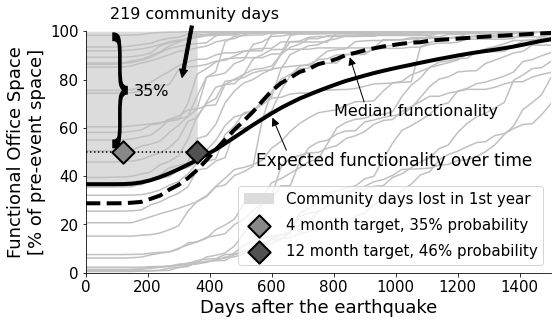

In [11]:
target_time = [30 * 4, 30 * 12]
target_threshold = [50] * len(target_time)

community_functionality_metric = 80
community_time_metric = 360

rec_idx = np.where(recovery_labels == 'total_downtime')[0]
occ_idx = np.where(occupancy_labels == 'Commercial Office')[0]
rup_idx = i_rup

community_recovery = community_recovery
[_,_,_,_,n_sims] = community_recovery.shape
sims_idx = range(1, n_sims, 36)
print('Number of sims plotted: ' + str(len(sims_idx)))

alpha = 1
[fig,ax] = plt.subplots(1,1,figsize=(8,4.5))
_ = plt.plot(time,community_recovery[:,rup_idx,occ_idx,rec_idx,sims_idx], color='silver', zorder=2, alpha=alpha)
community_mean = np.squeeze(np.mean(community_recovery[:,rup_idx,occ_idx,rec_idx,:],axis=2))
community_median = np.squeeze(np.median(community_recovery[:,rup_idx,occ_idx,rec_idx,:],axis=2))

time_idx = int(np.where(time==community_time_metric)[0]) + 1
_ = plt.fill_between(time[:time_idx], 100, community_mean[:time_idx], color='gainsboro', alpha=1, linewidth=0, label='Community days lost in 1st year')

_ = plt.plot(time,community_mean, color='k', linewidth=4, zorder=3)
_ = plt.plot(time,community_median, color='k', ls='--', linewidth=4, zorder=3)

# x = np.interp(community_functionality_metric, community_mean, time)
# _ = plt.scatter(x, community_functionality_metric, color='tab:blue', zorder=4, s=100, label='Time until functionality is '+str(community_functionality_metric)+'%')

color_values = [0.55, 0.75]
color_palettes = ['Greys']*2
target_colors = [mpl.cm.get_cmap(color_palettes[i])(color_values[i])[:-1] for i in range(len(color_values))] 

for p in range(len(target_time)):
    time_idx = np.where(time == target_time[p])[0]
    recovery_slice = np.squeeze(community_recovery[time_idx,rup_idx,occ_idx,rec_idx,:])
    threshold_idx = np.searchsorted(np.sort(recovery_slice), target_threshold[p])
    q = 100 * (1-threshold_idx/n_sims)

    label = '{0:.0f}'.format(target_time[p]/30) + ' month target, ' + '{0:.0f}'.format(q) + '% probability'
    _ = plt.scatter(target_time[p], target_threshold[p], marker='D', s=250, color=target_colors[p], edgecolor='k', linewidth=2, label=label, zorder=20)
_ = plt.plot([0,target_time[-1]],[50]*2,':k')
_ = ax.legend(handlelength=2, labelspacing=0.75)

_ = plt.xlim([0,1500])
_ = plt.ylim([0,100])
_ = ax.spines['right'].set_visible(False)
_ = ax.spines['top'].set_visible(False)

ylabel = 'Functional '+occupancy_labels[occ_idx][0]+',\n% of pre-event space'
ylabel = 'Functional Office Space\n[% of pre-event space]'
_ = plt.ylabel(ylabel)
_ = plt.xlabel('Days after the earthquake')
_ = plt.tight_layout()

# annotation

fontsize = 17
arrow_start = (600, 65)
arrow_end = (650,50)
text = ''
_ = plt.annotate(text, fontsize=fontsize, ha='center', va='top',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="-|>",
                                color='k',
                                connectionstyle="arc3"))
text = 'Expected functionality over time'
_ = plt.text(arrow_end[0]-100, arrow_end[1], text, ha='left', va='top', fontsize=fontsize)

fontsize = 16
arrow_start = (850, 90)
arrow_end = (900,70)
text = ''
_ = plt.annotate(text, fontsize=fontsize, ha='center', va='top',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="-|>",
                                color='k',
                                connectionstyle="arc3"))
text = 'Median functionality'
_ = plt.text(arrow_end[0]-100, arrow_end[1], text, ha='left', va='top', fontsize=fontsize)

curly(70,60,52, ax=None)
text = '{0:.0f}%'.format(summary_results.loc['baseline','% Likelihood of achieving\n50% functionality in 4 months'])
_ = plt.annotate(text,fontsize=fontsize,
            xy=(155, 75), ha='left', va='center'
            )

n_days = summary_results.loc['baseline','Mean community days lost\nwithin the first year']
text = '{0:.0f} community days'.format(n_days)
arrow_start=(310,80)
arrow_end  =(350,110)
_ = plt.annotate(text, fontsize=fontsize, ha='center', va='top',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle='simple',
                                color='k',
                                connectionstyle='arc3'))

filename = 'summary_statistics_orientation'
plt.savefig('figures_pdf/'+filename+'.pdf', bbox_inches='tight', pad_inches=0.1)
plt.savefig('figures_png/'+filename+'.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

### disaggregated recovery curves

In [51]:
def grid_plot_mean_community_recovery(community_recovery, time, xlim, i_rup, i_occ, sqft_totals, ax, legend):
    
    color_values = [0.15, 0.35, 0.65, 0.9]
    color_palettes = ['Greens', 'Greys', 'Oranges', 'Blues']
    colors = [mpl.cm.get_cmap(color_palettes[i])(color_values[i])[:-1] for i in range(len(color_values))] 
    if False:
        colors = [grayscale_version(colors[i]) for i in range(len(colors))]
    colors = [mpl.colors.to_hex(colors[i]) for i in range(len(colors))]
    colors = colors[1:]


    occ_labels = ['Residential', 'Commercial Office', 'All Occupancies']
    recovery_labels = ['functional_repair', 'impeding_factor_delay', 'functional_downtime', 'cordon_duration',
                       'cordon_induced_delay', 'total_delay', 'total_downtime']
    repair_idx = recovery_labels.index('functional_repair')
    no_cordon_downtime_idx = recovery_labels.index('functional_downtime')
    downtime_idx = recovery_labels.index('total_downtime')

    idx = repair_idx
    repair_time = 100 * np.mean(community_recovery[:, i_rup, i_occ, idx, :], axis=1)
    ax.fill_between(time, repair_time, 100, color=colors[0])

    idx = no_cordon_downtime_idx
    no_cordon_downtime = 100 * np.mean(community_recovery[:, i_rup, i_occ, idx, :], axis=1)
    if not np.array_equal(no_cordon_downtime, repair_time): 
        ax.fill_between(time, no_cordon_downtime, repair_time, color=colors[2])

    idx = downtime_idx
    downtime = 100 * np.mean(community_recovery[:, i_rup, i_occ, idx, :], axis=1)
    if not np.array_equal(downtime, no_cordon_downtime): 
        ax.fill_between(time, downtime, no_cordon_downtime, color=colors[1])
        
    if True:
        time_idx = np.where(time == 360)[0][0]
        ax.plot(time[:time_idx+1], downtime[:time_idx+1], color='k', linestyle='--')
        ax.plot([time[time_idx]]*2, [downtime[time_idx],100], color='k', linestyle='--')
    
    if legend:
        legend_elements = [Patch(facecolor=colors[0], label='Repair Time'),
                           Patch(facecolor=colors[2], label='Impeding Factors'),
                           Patch(facecolor=colors[1], label='Cordon Delays')
                          ]
        _ = ax.legend(handles=legend_elements, loc='lower right')
    
    _ = ax.grid(axis='both', color='gray', linestyle=':')

Magnitude  SourceIndex  RuptureIndex
0       7.25          127           637

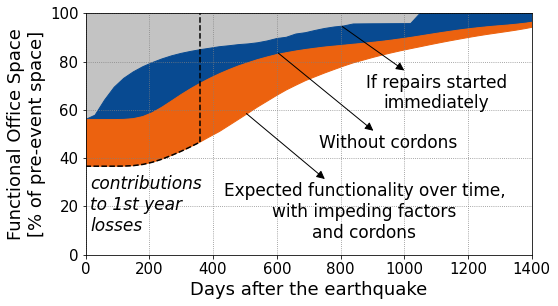

In [52]:
occ_labels = ['Residential', 'Office', 'All Occupancies']
i_occ = 1
xlim = [0, 1400]
case = 'baseline'
legend = False

[fig,ax] = plt.subplots(1,1,figsize=(8,4.5))

for i_rup in [i_rup]:
    ruptures[i_rup:i_rup+1]

    i_damage = cases[case]['i_damage']
    i_impeding_factors = cases[case]['i_impeding_factors']
    i_cordons = cases[case]['i_cordons']
    description = cases[case]['description']

    with h5py.File(output_filename, 'r') as hf:
        dset =   'Results' + \
                 '/CommunityDamage_' + str(i_damage) + \
                 '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
                 '/CordonLogistics/Cordons_' + str(i_cordons) + \
                 '/community_recovery'

        community_recovery = hf[dset][:]
        time = hf[dset].attrs.__getitem__('time')
        recovery_labels = hf[dset].attrs.__getitem__('recovery_labels')
        sqft_totals = hf[dset].attrs.__getitem__('sqft_totals')
        downtime_idx = np.where(recovery_labels=='total_downtime')[0]
        
grid_plot_mean_community_recovery(community_recovery, time, xlim, i_rup, i_occ, sqft_totals, ax, legend)
_ = ax.set_xlim(xlim)
_ = ax.set_ylim([0,100])

ylabel = 'Functional Office Space\n[% of pre-event space]'
_ = plt.ylabel(ylabel)
_ = plt.xlabel('Days after the earthquake')
_ = plt.tight_layout()


# annotations
fontsize = 17


# baseline annotations
i_case = 0
current_ax = ax

text = 'contributions\nto 1st year\nlosses'
_ = current_ax.text(15, 33, text, ha='left', va='top', fontsize=fontsize, style='italic')

arrow_start = (800, 95)
arrow_end = (1100,75)
text = 'If repairs started\nimmediately'
_ = current_ax.annotate(text, fontsize=fontsize, ha='center', va='top',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="<|-",
                                color='k',
                                connectionstyle="arc3"))

arrow_start = (600, 84)
arrow_end = (950,50)
text = 'Without cordons'
_ = current_ax.annotate(text, fontsize=fontsize, ha='center', va='top',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="<|-",
                                color='k',
                                connectionstyle="arc3"))

arrow_start = (500, 59)
arrow_end = (875,30)
text = 'Expected functionality over time,\nwith impeding factors\nand cordons'
_ = current_ax.annotate(text, fontsize=fontsize, ha='center', va='top',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="<|-",
                                color='k',
                                connectionstyle="arc3"))

filename = 'summary_disaggregation_orientation'
plt.savefig('figures_pdf/'+filename+'.pdf', bbox_inches='tight', pad_inches=0.1)
plt.savefig('figures_png/'+filename+'.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

Magnitude  SourceIndex  RuptureIndex
0       7.25          127           637

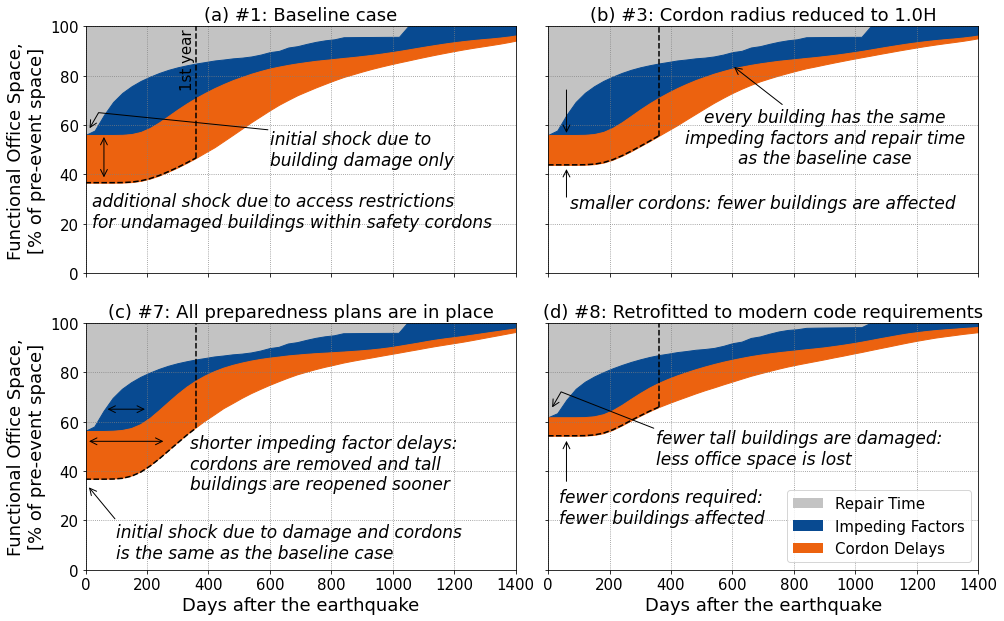

In [15]:
case_names_grid = ['baseline', 'cordon_extent',
              'tall_mitigation_all', 'tall_retrofit']
case_numbers_grid = [1,3,7,8]

occ_labels = ['Residential', 'Office', 'All Occupancies']
i_occ = 1
xlim = [0, 1400]

fig, ax = plt.subplots(2,2, figsize=(16,10), sharex=True, sharey=True)
case_location = [[0,0],[0,1],[1,0],[1,1]]
case_labels = ['(a)', '(b)', '(c)', '(d)']
plt.subplots_adjust(wspace=0.075)

for i_rup in [i_rup]:
    ruptures[i_rup:i_rup+1]
    for case, i_case in zip(case_names_grid, range(len(case_names_grid))):
        ax_current = ax[case_location[i_case][0],case_location[i_case][1]]
        if case == 'baseline':
            _ = ax_current.set_title(case_labels[i_case]+' #'+str(case_numbers_grid[i_case])+': Baseline case')
        else:
            _ = ax_current.set_title(case_labels[i_case]+' #'+str(case_numbers_grid[i_case])+': '+cases[case]['description'])

        i_damage = cases[case]['i_damage']
        i_impeding_factors = cases[case]['i_impeding_factors']
        i_cordons = cases[case]['i_cordons']
        description = cases[case]['description']

        with h5py.File(output_filename, 'r') as hf:
            dset =   'Results' + \
                     '/CommunityDamage_' + str(i_damage) + \
                     '/DowntimeLogistics/ImpedingFactors_' + str(i_impeding_factors) + \
                     '/CordonLogistics/Cordons_' + str(i_cordons) + \
                     '/community_recovery'

            community_recovery = hf[dset][:]
            time = hf[dset].attrs.__getitem__('time')
            recovery_labels = hf[dset].attrs.__getitem__('recovery_labels')
            sqft_totals = hf[dset].attrs.__getitem__('sqft_totals')
            downtime_idx = np.where(recovery_labels=='total_downtime')[0]
        
        if (case_location[i_case][0] == 1) & (case_location[i_case][1] == 1):
            legend = True
        else:
            legend = False
        grid_plot_mean_community_recovery(community_recovery, time, xlim, i_rup, i_occ, sqft_totals, ax_current, legend)
        _ = ax_current.set_xlim(xlim)
        _ = ax_current.set_ylim([0,100])
        
        if case_location[i_case][0] == 1:
            _ = ax_current.set_xlabel('Days after the earthquake')

            
        if case_location[i_case][1] == 0:
            _ = ax_current.set_ylabel('Functional '+occ_labels[i_occ] + ' Space,' + '\n' + '[% of pre-event space]', multialignment='center')


# annotations
fontsize = 17


# baseline annotations
i_case = 0
current_ax = ax[case_location[i_case][0],case_location[i_case][1]]

arrow_start = (10, 58)
arrow_end = (600,58)
text = ''
_ = current_ax.annotate(text, fontsize=fontsize, ha='left', va='center',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                color='k',
                                connectionstyle='arc, angleA=0, armA=0, angleB=60, armB=20, rad=0'))
text = 'initial shock due to\nbuilding damage only'
_ = current_ax.text(arrow_end[0], arrow_end[1], text, ha='left', va='top', fontsize=fontsize, style='italic')

arrow_start = (60, 56)
arrow_end = (arrow_start[0],38)
text = ''
_ = current_ax.annotate(text, fontsize=fontsize, ha='left', va='center',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="<->",
                                color='k',
                                connectionstyle="arc3"))
text = 'additional shock due to access restrictions\nfor undamaged buildings within safety cordons'
_ = current_ax.text(arrow_end[0]-40, arrow_end[1]-5, text, ha='left', va='top', fontsize=fontsize, style='italic')

text = '1st year'
_ = current_ax.text(355, 99, text, ha='right', va='top', rotation=90, fontsize=fontsize-2)


# cordon extent annotations
i_case = 1
current_ax = ax[case_location[i_case][0],case_location[i_case][1]]

arrow_start = (60, 56)
arrow_end = (arrow_start[0],75)
text = ''
_ = current_ax.annotate(text, fontsize=fontsize, ha='center', va='top',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                color='k',
                                connectionstyle="arc3"))
arrow_start = (arrow_start[0], 43)
arrow_end = (arrow_start[0],30)
text = ''
_ = current_ax.annotate(text, fontsize=fontsize, ha='center', va='top',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                color='k',
                                connectionstyle="arc3"))

_ = current_ax.text(arrow_start[0]+10, arrow_end[1]+2, 'smaller cordons: fewer buildings are affected', ha='left', va='top', fontsize=fontsize, style='italic')

arrow_start = (600, 84)
arrow_end = (900,67)
text = 'every building has the same\nimpeding factors and repair time\nas the baseline case'
_ = current_ax.annotate(text, fontsize=fontsize, ha='center', va='top', style='italic',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                color='k',
                                connectionstyle="arc3"))

# contingency options annotation
i_case = 2
current_ax = ax[case_location[i_case][0],case_location[i_case][1]]

arrow_start = (7, 34)
arrow_end = (100,20)
text = ''
_ = current_ax.annotate(text, fontsize=fontsize, ha='center', va='top', style='italic',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                color='k',
                                connectionstyle="arc3"))
text = 'initial shock due to damage and cordons\nis the same as the baseline case'
_ = current_ax.text(100, 19, text, ha='left', va='top', fontsize=fontsize, style='italic')


arrow_start = (65, 65)
arrow_end = (200,arrow_start[1])
text = ''
_ = current_ax.annotate(text, fontsize=fontsize, ha='left', va='center',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="<->",
                                color='k',
                                connectionstyle="arc3"))
arrow_start = (5, 52)
arrow_end = (260,arrow_start[1])
text = ''
_ = current_ax.annotate(text, fontsize=fontsize, ha='left', va='center',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="<->",
                                color='k',
                                connectionstyle="arc3"))
text = 'shorter impeding factor delays:\ncordons are removed and tall\nbuildings are reopened sooner'
_ = current_ax.text(arrow_end[0]+80, arrow_end[1]+3, text, ha='left', va='top', fontsize=fontsize, style='italic')

# retrofit annotation
i_case = 3
current_ax = ax[case_location[i_case][0],case_location[i_case][1]]

arrow_start = (10, 65)
arrow_end = (350,57)
text = ''
_ = current_ax.annotate(text, fontsize=fontsize, ha='left', va='center',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                color='k',
                                connectionstyle='arc, angleA=0, armA=0, angleB=60, armB=20, rad=0'))
text = 'fewer tall buildings are damaged:\nless office space is lost'
_ = current_ax.text(arrow_end[0], arrow_end[1], text, ha='left', va='top', fontsize=fontsize, style='italic')


arrow_start = (60, 53)
arrow_end = (arrow_start[0],35)
text = ''
_ = current_ax.annotate(text, fontsize=fontsize, ha='center', va='top',
                xy=arrow_start, xycoords='data',
                xytext=arrow_end, textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                color='k',
                                connectionstyle="arc3"))

_ = current_ax.text(arrow_start[0]-25, arrow_end[1]-2, 'fewer cordons required:\nfewer buildings affected', ha='left', va='top', fontsize=fontsize, style='italic')

filename = 'downtime_deagg_grid_annotated'
plt.savefig('figures_pdf/'+filename+'.pdf', bbox_inches='tight', pad_inches=0.1)
plt.savefig('figures_png/'+filename+'.png', bbox_inches='tight', pad_inches=0.1)

### policy comparisons

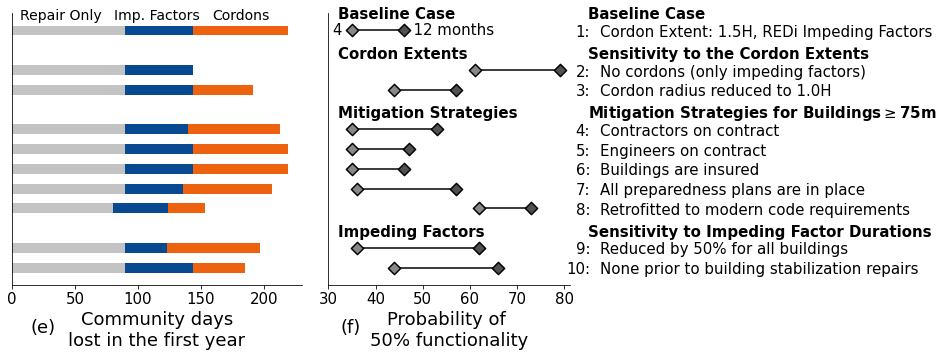

In [17]:
# set colors
color_values = [0.15, 0.35, 0.65, 0.9]
color_palettes = ['Greens', 'Greys', 'Oranges', 'Blues']
colors = [mpl.cm.get_cmap(color_palettes[i])(color_values[i])[:-1] for i in range(len(color_values))] 
colors = [mpl.colors.to_hex(colors[i]) for i in range(len(colors))]
colors = [colors[1],colors[3],colors[2]]

fig_width = 12
fig_height = 6
fig_width = 10
fig_height = 5
bar_width = 0.5
location = [0, 2,3, 5,6,7,8,9, 11,12]

gridspec_kw = {'wspace':0.1, 'width_ratios':(1.2,1)}
fig, ax = plt.subplots(1,2,figsize=(fig_width,fig_height), gridspec_kw=gridspec_kw)

# plot disaggregated community days lost
ax_i = 0
left = 0
for i in [0,1,2]:
    deag_days = summary_results[deag_col[i]].values
    _ = ax[ax_i].barh(location, deag_days, height=bar_width, left=left, color=colors[i])
    left = left + deag_days
    
_ = ax[ax_i].invert_yaxis()
_ = ax[ax_i].set_yticks([])
ylim = ax[ax_i].get_ylim()

_ = ax[ax_i].set_xlabel('Community days\nlost in the first year') 
_ = ax[ax_i].spines['right'].set_visible(False)
_ = ax[ax_i].spines['top'].set_visible(False)

# plot probability of achieving targets
ax_i = 1
color_values = [0.55, 0.75]
color_palettes = ['Greys']*2
target_colors = [mpl.cm.get_cmap(color_palettes[i])(color_values[i])[:-1] for i in range(len(color_values))] 
for i_t, t in enumerate(target_time):
    target = summary_results[policy_col[i_t]].values
    _ = ax[ax_i].scatter(target, location, marker='D', s=75, color=target_colors[i_t], edgecolor='k', linewidth=1.5)
for i_l, l in enumerate(location):
    x = [summary_results[policy_col[0]].values[i_l], summary_results[policy_col[1]].values[i_l]]
    _ = ax[ax_i].plot(x, [l]*2, color='k', zorder=0)

lower_bound = 30
_ = ax[ax_i].set_xlim(lower_bound)
_ = ax[ax_i].set_ylim(ylim)
  
_ = ax[ax_i].set_xlabel('Probability of \n50% functionality')
_ = ax[ax_i].set_yticks([]) 
_ = ax[ax_i].spines['right'].set_visible(False)
_ = ax[ax_i].spines['top'].set_visible(False)
xticks = ax[ax_i].get_xticks() 


x = [5, 85]
y = np.array([-1, 1, 4, 10])+0.2
labels = ['Baseline Case', 'Sensitivity to the Cordon Extents', r'Mitigation Strategies for Buildings$\geq$75m', 'Sensitivity to Impeding Factor Durations']
for ax_i in [1]:
    for i in range(len(labels)):
        _ = ax[ax_i].text(x[ax_i], y[i], labels[i], va='center', fontweight='heavy')

labels = ['Baseline Case', 'Cordon Extents', r'Mitigation Strategies', 'Impeding Factors']        
x = 32
for i in range(len(labels)):
    _ = ax[ax_i].text(x, y[i], labels[i], va='center', fontweight='heavy')
        
ax_i = 1
x = 87.5
for i in range(len(location)):
    _ = ax[ax_i].text(x-2, location[i]+0.1, str(i+1)+':', va='center', ha='right', style='normal')
    _ = ax[ax_i].text(x, location[i]+0.1, cases[case_names[i]]['description'], va='center')

y = 0
x = summary_results[policy_col[0]].values[0]
_ = ax[ax_i].text(x, y, '4  ', va='center', ha='right')
x = summary_results[policy_col[1]].values[0]
_ = ax[ax_i].text(x, y, '  12 months', va='center', ha='left')
  
_ = ax[ax_i].set_xticks([30, 40, 50, 60, 70, 80])   

_ = ax[ax_i].text(32.5, 15.5, '(f)', fontsize='large', va='bottom')
    
ax_i = 0
y = -0.75
x = [39, 115, 182]
for i, label in enumerate(['Repair Only', 'Imp. Factors', 'Cordons']):
    _ = ax[ax_i].text(x[i], y, label, va='center', ha='center', fontsize=14)
    
_ = ax[ax_i].text(15, 15.5, '(e)', fontsize='large', va='bottom')

filename = 'policy_comparison'
_ = plt.savefig('figures_pdf/'+filename+'.pdf', bbox_inches='tight')
_ = plt.savefig('figures_png/'+filename+'.png', dpi=500, bbox_inches='tight')